<img src="header-exploration.png"/>

# Objectif du projet

>Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une **photo et une description**.
>Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
>Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire **d'automatiser** cette tâche.

>La mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article : 
> - analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering.
> - Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters.

>Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

# Execution du notebook

Le présent notebook suppose l'arborescence suivante, pour le chargement des données et l'écriture des résultats : 

```bash
├───data
│   ├───processed
│   └───raw
│       ├───flipkart_com-ecommerce_sample_1050.csv
│       └───images/*.jpg
└───notebooks
    ├───1_exploration.ipynb
    ├───2_text_classification.ipynb
    ├───3_image_classification.ipynb
    ├───4_text+image_classification.ipynb
    ├───dumbbell.png
    ├───header-exploration.png
    ├───header-image-classification.png
    ├───header-text+image-classification.png
    ├───header-text-classification.png
    └───hook-blue.jpg
```

# Initialisation du projet

In [1]:
# Math & data
import numpy as np
import pandas as pd
import math
import os
from os import listdir
from os.path import isfile, join
import time
import itertools
import shutil
import pickle

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns
import datetime

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow_text

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

import transformers

os.environ["TF_KERAS"]='1'

In [6]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [7]:
# Personal libraries
import DisplotData
import DisplotML
from DisplotData import bcolors
from DisplotData import print_debug

# Chargement des données

In [8]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'

In [9]:
data_00 = pd.read_csv(data_raw_dir+'flipkart_com-ecommerce_sample_1050.csv')

In [10]:
data_00.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [11]:
data_00.shape

(1050, 15)

In [12]:
data_00.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

# Exploration des données

## Rôle des colonnes

In [13]:
data_00.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

### `uniq_id`

La colonne `uniq_id` joue le rôle de clé du produit.

### `crawl_timestamp`

### `product_url`

### `product_name`

In [14]:
data_00['product_name'].values

array(['Elegance Polyester Multicolor Abstract Eyelet Door Curtain',
       'Sathiyas Cotton Bath Towel',
       'Eurospa Cotton Terry Face Towel Set', ...,
       'Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker',
       'Wallmantra Medium Vinyl Sticker Sticker',
       'Uberlyfe Large Vinyl Sticker'], dtype=object)

Cette colonne est vachement cool pour pré-décrire le produit !

### `product_category_tree`

On va ne pas tricher.

In [15]:
data_00['product_category_tree'].values[12]

'["Watches >> Wrist Watches >> Lois Caron Wrist Watches"]'

In [16]:
data_00['product_category_tree'].values[125]

'["Beauty and Personal Care >> Body and Skin Care >> Hand Care >> Manicure and Kits >> Sally Hansen Manicure and Kits"]'

Enoncé : pas de classification supervisée ! Mais comment calculer un score ARI ?!
--> Yann : exploiter quand même les catégories, pour évaluer la qualité des approches. Donc apprendre les "labels". 

Comptons le nombre de catégories "feuilles" du dataset :

In [17]:
categs_final = data_00['product_category_tree']
categs_final.value_counts().shape

(642,)

Ca fait beaucoup. Et beaucoup de produits seront seuls dans leur catégorie :

In [18]:
categs_final.value_counts()

["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wrist Watches >> Petrol Wrist Watches"]                                   1
Name: product_categor

In [19]:
categs_1st = [str(c).split(" >> ")[0].replace('["','') for c in categs_final.values]
print(list(np.unique(categs_1st)))
print(len(np.unique(categs_1st)))

['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']
7


In [21]:
categs_1st[0:20]

['Home Furnishing',
 'Baby Care',
 'Baby Care',
 'Home Furnishing',
 'Home Furnishing',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches']

In [22]:
data_00['categs_1st'] = categs_1st
data_00['categs_1st']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: categs_1st, Length: 1050, dtype: object

In [23]:
data_00['categs_1st'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: categs_1st, dtype: int64

On obtient 7 catégories parfaitement équilibrées, cela paraît suffisant pour couvrir le dataset. 

In [24]:
data_00['categs_1st'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Si on pousse au deuxième rang :

In [25]:
categs_2nd = [str(c).split(" >> ")[0:2] for c in categs_final.values]

categs_2nd = [" >> ".join(c) for c in categs_2nd]
categs_2nd = [c.replace('["','') for c in categs_2nd]
categs_2nd = [c.replace('"]','') for c in categs_2nd]
categs_2nd[0:20]

['Home Furnishing >> Curtains & Accessories',
 'Baby Care >> Baby Bath & Skin',
 'Baby Care >> Baby Bath & Skin',
 'Home Furnishing >> Bed Linen',
 'Home Furnishing >> Bed Linen',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches',
 'Watches >> Wrist Watches']

In [26]:
print(len(np.unique(categs_2nd)))

62


In [27]:
for c in list(np.unique(categs_2nd)):
    print(c)

Baby Care >> Baby & Kids Gifts
Baby Care >> Baby Bath & Skin
Baby Care >> Baby Bedding
Baby Care >> Baby Grooming
Baby Care >> Diapering & Potty Training
Baby Care >> Feeding & Nursing
Baby Care >> Furniture & Furnishings
Baby Care >> Infant Wear
Baby Care >> Strollers & Activity Gear
Beauty and Personal Care >> Bath and Spa
Beauty and Personal Care >> Beauty Accessories
Beauty and Personal Care >> Body and Skin Care
Beauty and Personal Care >> Combos and Kits
Beauty and Personal Care >> Eye Care
Beauty and Personal Care >> Fragrances
Beauty and Personal Care >> Hair Care
Beauty and Personal Care >> Health Care
Beauty and Personal Care >> Makeup
Beauty and Personal Care >> Men's Grooming
Beauty and Personal Care >> Women's Hygiene
Computers >> Computer Components
Computers >> Computer Peripherals
Computers >> Laptop Accessories
Computers >> Laptops
Computers >> Network Components
Computers >> Software
Computers >> Storage
Computers >> Tablet Accessories
Home Decor & Festive Needs >> Ca

63 catégories, ça fait à nouveau beaucoup, mais on verra plus tard ce que la classif non supervisée nous apporte et si certaintes catégories de rang 2 sont identifiées.

In [28]:
data_00['categs_2nd'] = categs_2nd

### `pid`

### `retail_price`

### `discounted_price`

### `image`

In [29]:
data_00['image'].values

array(['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
       '7b72c92c2f6c40268628ec5f14c6d590.jpg',
       '64d5d4a258243731dc7bbb1eef49ad74.jpg', ...,
       '5912e037d12774bb73a2048f35a00009.jpg',
       'c3edc504d1b4f0ba6224fa53a43a7ad6.jpg',
       'f2f027ad6a6df617c9f125173da71e44.jpg'], dtype=object)

Cette colonne nous permettra d'associer l'image dans le répertoire d'images :

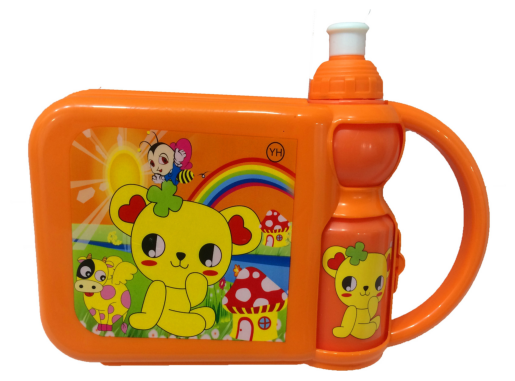

In [31]:
id = data_00.loc[69, 'image']
id

DisplotData.display_external_images([data_raw_dir+f"images/{id}"])

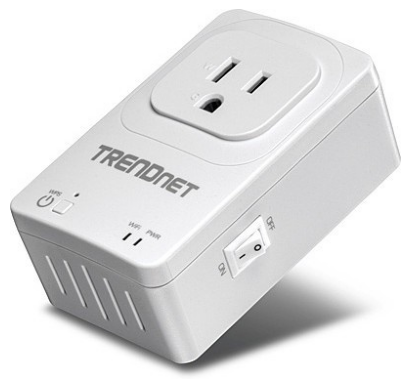

In [32]:
id = data_00.loc[345, 'image']
id

DisplotData.display_external_images([data_raw_dir+f"images/{id}"])

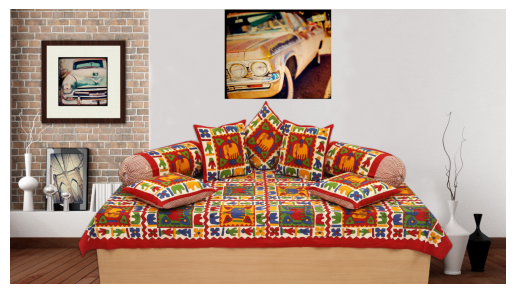

In [33]:
id = data_00.loc[78, 'image']
id

DisplotData.display_external_images([data_raw_dir+f"images/{id}"])

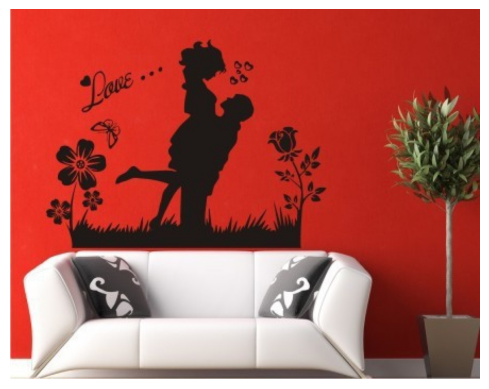

In [34]:
id = data_00.loc[85, 'image']
id

DisplotData.display_external_images([data_raw_dir+f"images/{id}"])

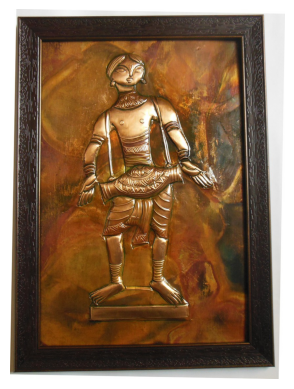

In [35]:
id = data_00.loc[94, 'image']
id

DisplotData.display_external_images([data_raw_dir+f"images/{id}"])

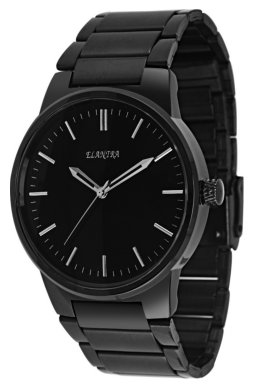

In [36]:
id = data_00.loc[29, 'image']
id

DisplotData.display_external_images([data_raw_dir+f"images/{id}"])

In [37]:
data_00.loc[29, 'description']

'Elantra S 10 Analog Watch  - For Boys, Men - Buy Elantra S 10 Analog Watch  - For Boys, Men  S 10 Online at Rs.950 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

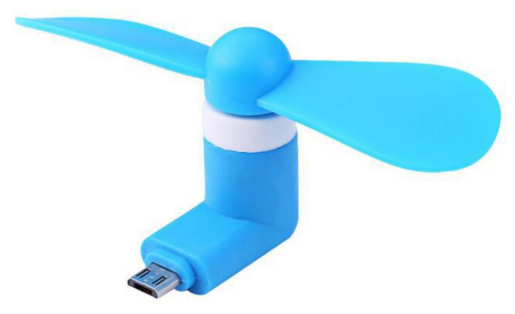

In [38]:
id = data_00.loc[53, 'image']
id

DisplotData.display_external_images([data_raw_dir+f"images/{id}"])

In [39]:
data_00.loc[53, 'description']

'Key Features of JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan System Requirements: OTG Enabled Android Smart Phone Material: Plastic,Specifications of JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan (Multicolor) General Brand JRB Type USB Fan Model Name 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Material Plastic System Requirements OTG Enabled Android Smart Phone Model ID Portable 1038 Color Multicolor In the Box Sales Package 1 MICRO USB FAN'

In [40]:
data_00.loc[53, 'product_name']

'JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan'

### `is_FK_Advantage_product`

### `description`

In [41]:
data_00['description'].values

array(['Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so t

Baby Care :
---------


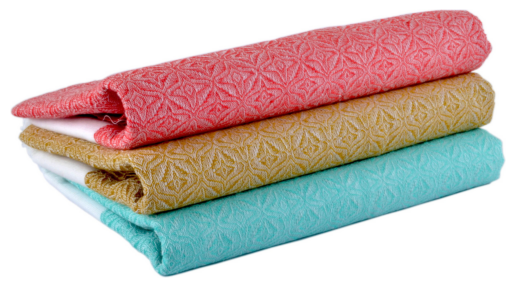

[Baby Care] Product name : Sathiyas Cotton Bath Towel
[Baby Care] Description  : Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel


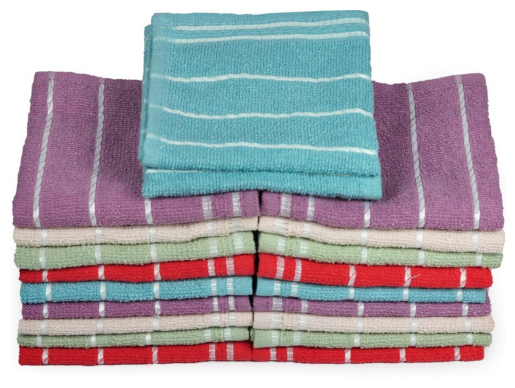

[Baby Care] Product name : Eurospa Cotton Terry Face Towel Set
[Baby Care] Description  : Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Mate

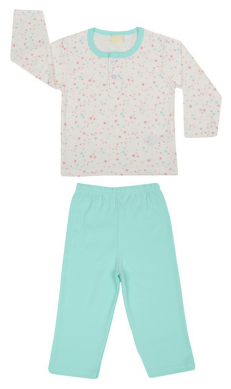

[Baby Care] Product name : Mom and Kid Baby Girl's Printed Green Top & Pyjama Set
[Baby Care] Description  : Key Features of Mom and Kid Baby Girl's Printed Green Top & Pyjama Set Fabric: Cotton Brand Color: Green,Mom and Kid Baby Girl's Printed Green Top & Pyjama Set Price: Rs. 309 Girls Pyjama set,Specifications of Mom and Kid Baby Girl's Printed Green Top & Pyjama Set General Details Pattern Printed Ideal For Baby Girl's Night Suit Details Fabric Cotton Type Top & Pyjama Set Neck Round Neck In the Box 1 Top & Pyjama Set


Beauty and Personal Care :
------------------------


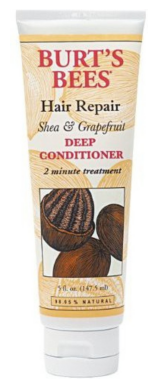

[Beauty and Personal Care] Product name : Burt s Bees Hair Repair Shea And Grapefruit Deep Conditioner
[Beauty and Personal Care] Description  : Key Features of Burt s Bees Hair Repair Shea And Grapefruit Deep Conditioner Ideal For: Boys, Girls Applied For: Deep Conditioning Hair Condition: Damaged Hair Hair Type: Dry Hair,Specifications of Burt s Bees Hair Repair Shea And Grapefruit Deep Conditioner (147.5 ml) Conditioner Traits Hair Condition Damaged Hair Hair Type Dry Hair Applied For Deep Conditioning Ideal For Boys, Girls General Traits Brand Burt s Bees Quantity 147.5 ml Model Name Hair Repair Shea And Grapefruit Deep Conditioner In the Box 1 Conditioner


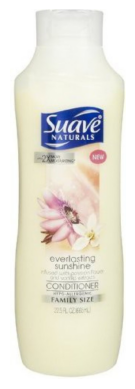

[Beauty and Personal Care] Product name : Suave Naturals Everlasting Sunshine Conditioner
[Beauty and Personal Care] Description  : Key Features of Suave Naturals Everlasting Sunshine Conditioner Ideal For: Boys, Girls Applied For: Conditioning Hair Condition: Damaged Hair Hair Type: Dry Hair,Specifications of Suave Naturals Everlasting Sunshine Conditioner (665 ml) Conditioner Traits Hair Condition Damaged Hair Hair Type Dry Hair Applied For Conditioning Ideal For Boys, Girls General Traits Brand Suave Quantity 665 ml Model Name Naturals Everlasting Sunshine Conditioner In the Box 1 Conditioner


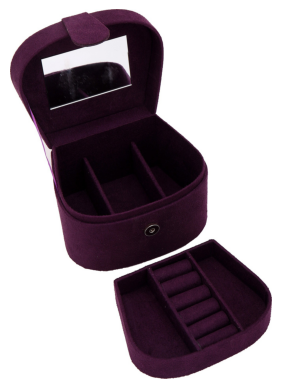

[Beauty and Personal Care] Product name : Borse N16 Make Up And Jewellery Vanity Case
[Beauty and Personal Care] Description  : Buy Borse N16 Make Up And Jewellery Vanity Case for Rs.680 online. Borse N16 Make Up And Jewellery Vanity Case at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


Computers :
---------


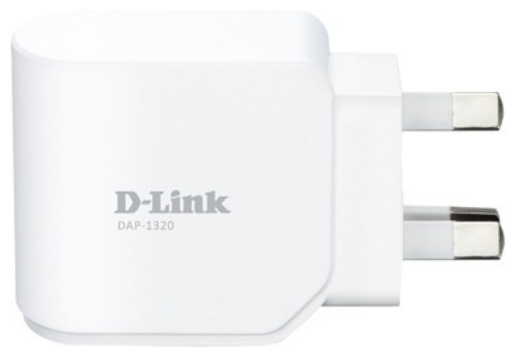

[Computers] Product name : D-Link DAP1320
[Computers] Description  : Key Features of D-Link DAP1320 QRS app(iOS,Android),Specifications of D-Link DAP1320 (White) Speed Wireless Speed 300 Mbps DSL Modem Speed 300 Mbps General Brand D-Link In The Box Extender Plug Model DAP1320 Type Range Extenders/Repeaters Color White Warranty Covered in Warranty No damage Warranty Summary 3years Service Type No damage Not Covered in Warranty damaged will not repair Dimensions Weight 69 g Connectivity Number of Antennae 2 Number of USB Ports 0 Antennae Internal Supported Protocols Standard IEEE IEEE 802.11n/g/b Operating Conditions Operating Humidity Operating: 10% to 90% non-condensing // Storage: 5% to 95% non-condensing Temperature Operating: 0 to 40 °C (32 to 104 °F)//Storage: -20 to 65 °C (-4 to 149 °F) degree C Additional Features Certification FCC, IC, CE


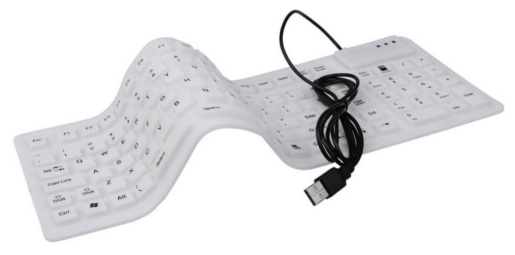

[Computers] Product name : RoQ Slim Multimedia 105key Flexible Wired USB Flexible Keyboard
[Computers] Description  : Key Features of RoQ Slim Multimedia 105key Flexible Wired USB Flexible Keyboard Size: Handheld,RoQ Slim Multimedia 105key Flexible Wired USB Flexible Keyboard (White) Price: Rs. 399 Working Environment. It Fits Easily In Your Briefcase Or Backpack. The Keyboard Can Be Cleaned With Water, Alcohol Or Disinfectant To Help Prevent The Spread Of The Disease And Germs. It Is Suitable For Public Place Use Such As School, Restaurant, Or Hospital Where Clean Keyboard Is A Requirement. This Sealed Keyboard Can Be Easily Cleaned, Also Good For Use In Dusty Area Such As Factory, Or Outdoor. Quiet Keystroke Is A Good Match For Library Use. If You Are Not Used To This Keyboard, You May Push These Keys A Tiny Bit Harder To Get Output. Dustproof Washable Usb Plug Weight: 0.45lbs (200g) Operation Temperature Is -20c- +60c. Storage Temperature Is -30c - +70c,Specifications of RoQ Slim Mu

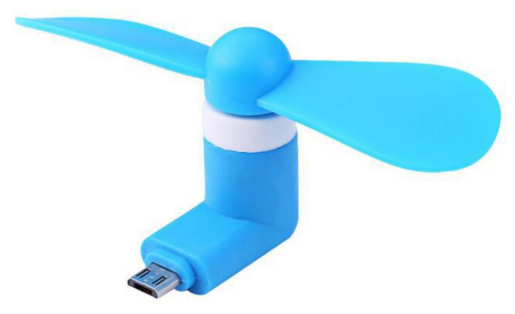

[Computers] Product name : JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan
[Computers] Description  : Key Features of JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan System Requirements: OTG Enabled Android Smart Phone Material: Plastic,Specifications of JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan (Multicolor) General Brand JRB Type USB Fan Model Name 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Material Plastic System Requirements OTG Enabled Android Smart Phone Model ID Portable 1038 Color Multicolor In the Box Sales Package 1 MICRO USB FAN


Home Decor & Festive Needs :
--------------------------


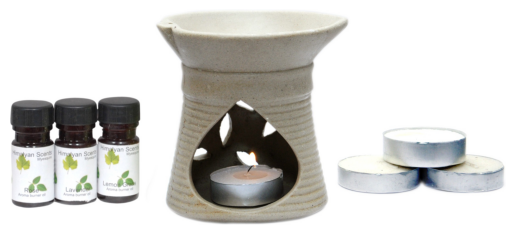

[Home Decor & Festive Needs] Product name : Myesquire Ceramic Burner Pot Lemongrass Liquid Air Freshener
[Home Decor & Festive Needs] Description  : Myesquire Ceramic Burner Pot Lemongrass Liquid Air Freshener (30 ml)
                         Price: Rs. 245
				
			Illuminate Every Corner Of Your Living Room In Style With This Home Fragrance Electric Burner Combo With Fragrance That Is Brought To You By Myesquire. This Is A Very Unique, Useful And Value for Money Product For Home Decoration And Fragrance. This Unique Combo Contains Aroma Burner With All Accessories and is ready to use . Put A Small Amount 1-2 Tea Spoon Of Aroma Oil On The Bowl Surface And Light The Tea Light and After Few Minutes As The Oil Heats Up, The Fragrance Will Spread In The Room. And You Will Be All Set To Enjoy The Captivating Aroma. Keep It Away From Children As Surface Becomes Hot.
Illuminate Every Corner Of Your Living Room In Style With This Home Fragrance Electric Burner Combo With Fragrance That Is Brou

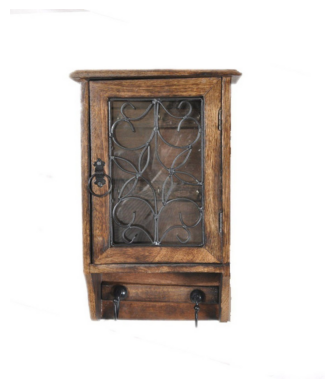

[Home Decor & Festive Needs] Product name : VarEesha Wooden Key Holder
[Home Decor & Festive Needs] Description  : Key Features of VarEesha Wooden Key Holder Hand made using wrought iron and mango wood Color - Brown Material - Sheesham wood Care instructions : Clean with a wet cloth and wipe gently.,VarEesha Wooden Key Holder (8 Hooks, Multicolor) Price: Rs. 1,199 Traditional design combined with utility, this wood and iron designed keybox is a convenient place to store all your keys. The iron design has a glass back to protect from dust and makes this box very manageable. Has 6 hooks inside for your keys which are less frequently used and 2 bigger hooks outside for car keys and other bigger keys which are used daily.,Specifications of VarEesha Wooden Key Holder (8 Hooks, Multicolor) General Brand VarEesha Model Number VSSWH001 Material Wooden Number of Hooks 8 Color Multicolor In the box Sales Package 1 KeyHanger Pack of 1 Dimensions Weight 900 g Other Dimensions L*B*H-20x10x35 cms


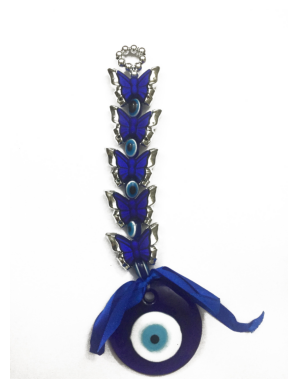

[Home Decor & Festive Needs] Product name : Treasure Showpiece  -  23 cm
[Home Decor & Festive Needs] Description  : Key Features of Treasure Showpiece  -  23 cm Polyresin Height - 23 cm Width - 1 cm,Specifications of Treasure Showpiece  -  23 cm (Polyresin, Blue) General Brand Treasure Model Number TE6 Type Fengshui Material Polyresin Color Blue Dimensions Height 23 cm Width 1 cm Depth 1 cm In the Box Sales Package 1 show piece


Home Furnishing :
---------------


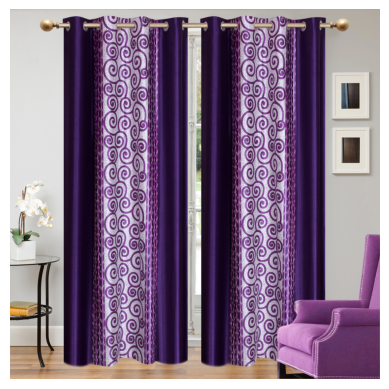

[Home Furnishing] Product name : Elegance Polyester Multicolor Abstract Eyelet Door Curtain
[Home Furnishing] Description  : Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of j

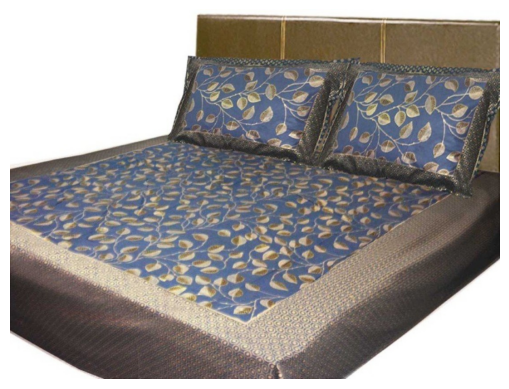

[Home Furnishing] Product name : SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet
[Home Furnishing] Description  : Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet (1 Bedsheet,2 Pillow Cover, Multicolor) General Brand SANTOSH ROYAL FASHION Machine Washable Yes Type Flat Material Cotton Model Name Gold Design Royal Cotton Printed Wedding & Gifted Double Bedsheet With 2 Pillow cover Model ID goldbedi-38 Color Multicolor Size King Fabric Care Machine Wash, Do Not Bleach Dimensions Flat Sheet Width 90 inch / 230 cm Fitted Sheet Width 228 cm Pillow Cover Width 16 inch / 43 cm Pillow Cover Length 28 inch / 72 cm Fitted Sheet Depth 280 cm Fitted Sheet Length 278 cm Flat Sheet Depth 282 cm Flat Sheet Length 110 inch / 280 cm In the Box Number of Contents in Sales Package 1 Sales Package 1 Bedsheet,2 Pillow Cover


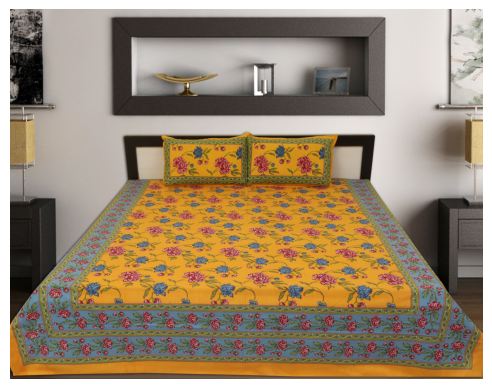

[Home Furnishing] Product name : Jaipur Print Cotton Floral King sized Double Bedsheet
[Home Furnishing] Description  : Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice bed sheet made up of 100% cotton to give you comfort. This bed sheet is hand printed. This bedsheet gives nice look to your room And its fast colour and good quality gives this bedsheet long life.,Specifications of Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) General Machine Washable Yes Brand Jaipur Print Type Flat Model Name jaipur117 Material Cotton Thread Count 140 Model ID jaipur117 Fabric Care machinewash, do not bleach Size King Color White Warranty waranty of the product only for manufacturing defect only and product will exchange onle when it is not used and returne its origional packing Dimensions Flat Sheet Width 86 inc

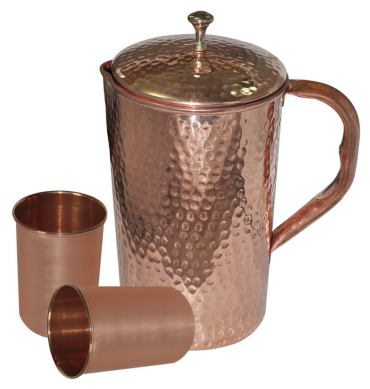

[Kitchen & Dining] Product name : Dungri India Craft Ducjug010-ducgl012-2 Jug Glass Set
[Kitchen & Dining] Description  : Key Features of Dungri India Craft Ducjug010-ducgl012-2 Jug Glass Set Jug: Height- 8 inches, Dia - 4.2 inches, Depth 7.5 inches, Width 7 inches,capacity 1744 ml, Weight - 430 Grams,Dungri India Craft Ducjug010-ducgl012-2 Jug Glass Set (Copper) Price: Rs. 1,399 Copper Utensils And Serving Copper Ware Helped To Prevent The Spread Of Diseases. In Many Tests It Showed That 99.9% Of The Bacteria On Copper Alloy Surfaces (With 65% Or Greater Copper Content) Were Eliminated Within 2 Hours Of Exposure. According To Research At Southampton University In The U.K., Mrsa Microbes Remain Alive On Stainless Steel Surfaces For Up To Three Days, Whereas The Same Microbes On A Copper Surface Are Eliminated Within 90 Minutes. These Copper Serving Ware Are Preferred Because It Is Durable And It Has Excellent Characteristics. The Ageless Use Of Copper Bears Testimony To Its Myriad Virt

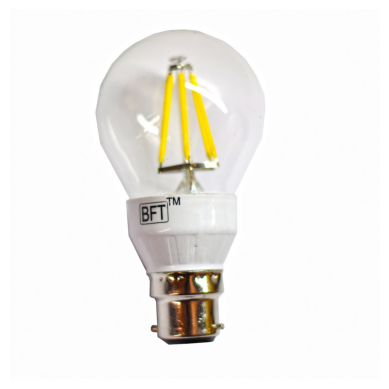

[Kitchen & Dining] Product name : BFT 6 W LED Bulb
[Kitchen & Dining] Description  : Key Features of BFT 6 W LED Bulb Pack of 1 Bulb,BFT 6 W LED Bulb (White) Price: Rs. 350 Introducing new technology in led lighting LED filament. Best suited for chandeliers table lamps and light fixtures in general as it spreads light 360-degrees,Specifications of BFT 6 W LED Bulb (White) General Brand BFT Model Number BFTCW6 Body and Design Features Material Glass Bulb Base B22 Lighting Features Light Color White Bulb Type LED Lumen 700 Power Features Power Consumption 6 W In the Box Sales Package 1 Bulb Pack of 1


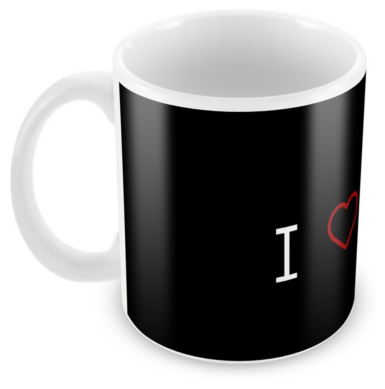

[Kitchen & Dining] Product name : AKUP i-loves-music Ceramic Mug
[Kitchen & Dining] Description  : Key Features of AKUP i-loves-music Ceramic Mug Pack of 1 Mug,AKUP i-loves-music Ceramic Mug (300 ml) Price: Rs. 259 AKUP Ceramic coffee mugs gives you the best quality printed mugs which you can gift to your loved ones. We provide good quality of products with packing. Coffee mugs made of ceramic clay with the volume capacity of 300ml each. You can buy it for yourself to make your moment unforgettable forever. Specifications Product Dimensions: Mugs - Height: 9.5 cms, Diameter: 8 cms. Item Type: Coffee Mug Color: Multi-Color Material: Clay Finish: Glossy Specialty: Lovely Style Wash care: Remove dirt by using a soft fabric to clean and then wipe with a moist cloth. Disclaimer: The fine design, pattern and color tone of the product may vary slightly from that shown in the image. However, there would not be any compromise in quality. Brand: AKUP designs & co,Specifications of AKUP i-loves-m

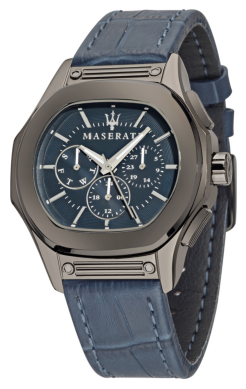

[Watches] Product name : Maserati Time R8851116001 Analog Watch  - For Boys
[Watches] Description  : Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch  - For Boys  R8851116001 Online at Rs.24400 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!


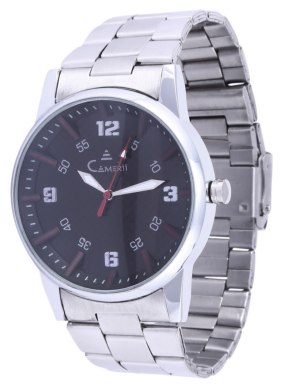

[Watches] Product name : Camerii WM64 Elegance Analog Watch  - For Men, Boys
[Watches] Description  : Camerii WM64 Elegance Analog Watch  - For Men, Boys - Buy Camerii WM64 Elegance Analog Watch  - For Men, Boys  WM64 Online at Rs.449 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!


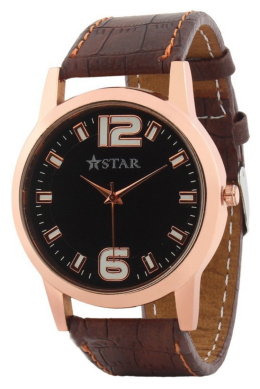

[Watches] Product name : T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
[Watches] Description  : T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
                         Price: Rs. 399
				
			Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.
Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.




In [43]:
N = 3
for categ in list(np.unique(categs_1st)):
    print(bcolors.BOLD+bcolors.HEADER+categ+' :'+'\n'+'-'*len(categ)+bcolors.ENDC)
    df_name = data_00.loc[data_00['categs_1st']==categ, 'product_name']
    df_desc = data_00.loc[data_00['categs_1st']==categ, 'description']
    df_imag = data_00.loc[data_00['categs_1st']==categ, 'image']
    for ind in range(N):
        id = df_imag.iloc[ind]
        DisplotData.display_external_images([data_raw_dir+f"images/{id}"])
        print(bcolors.BOLD+f"[{categ}] Product name : "+bcolors.ENDC+f"{df_name.iloc[ind]}")
        print(bcolors.BOLD+f"[{categ}] Description  : "+bcolors.ENDC+f"{df_desc.iloc[ind]}")
    print('\n')

**Commentaires :**
 - Pas mal de descriptions sont **doublées**, mais avec des altérations, donc pas facilement détectable
 - Pas mal de descriptions sont avec des majuscules à chaque première lettre, mais pas toutes
 - Pas mal de descriptions reprennent le nom de produit, mais pas toutes (ex : `AKUP i-loves-music Ceramic Mug`)
 - Des caractères spéciaux (`±3%`)
 - Des stopwords (`Key Features`) inutiles
 - Il y a bien du "Bengaglish" dans les noms et descriptions : `"dohar"` (dessus de lit). Or l'embedding EN `word2vec` ne connaît probablement pas ce(s) mots. En dehors de l'ajout ad-hoc de ce type de vocabulaire dans le dictionnaire d'entraînement de `word2vec`, il n'y a qu'un apprentissage supervisé pour apprendre la catégorie.

In [44]:
nb_unrepeated_tokens = 0
nb_total_name_tokens = 0
nb_prods_w_unreap_tk = 0
names = data_00['product_name'].values
descs = data_00['description'].values
nm_old = None
for nm, ds in zip(names, descs):
    tokens = nm.split(' ')
    nb_total_name_tokens += len(tokens)
    for tk in tokens:
        if not tk in ds:
            nb_unrepeated_tokens += 1
            if not nm==nm_old:
                nb_prods_w_unreap_tk += 1
                nm_old = nm

print(f"Nombre total de tokens dans les noms de produits non repris dans la description : {nb_unrepeated_tokens}")
print(f"Nombre total de tokens dans les noms de produits : {nb_total_name_tokens}")
print(f"Nombre de produits avec des pertes de tokens {nb_prods_w_unreap_tk}")

Nombre total de tokens dans les noms de produits non repris dans la description : 1
Nombre total de tokens dans les noms de produits : 7998
Nombre de produits avec des pertes de tokens 1


Donc les descriptions reprennent quasiment 100% des termes présents dans les noms de produits.

### `product_rating`

### `overall_rating`

### `brand`

### `product_specifications`

La colonne `product_specifications` semble contenir des informations supplémentaires :

In [45]:
data_00.product_specifications.values

array(['{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}',
       '{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {

Ces informations peuvent aider à la catégorisation (ex : _"Leaves no sticky residue on walls. Can be applied on any smooth, clean and dry surface like wall, glass, mirror, tile, furniture, automotive surfaces etc"_, mais on ne sait pas si elles peuvent être exploitées dans le projet.

## Explorations

In [47]:
data_00.loc[29, 'description']

'Elantra S 10 Analog Watch  - For Boys, Men - Buy Elantra S 10 Analog Watch  - For Boys, Men  S 10 Online at Rs.950 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

Le texte est très peu informatif : seul le mot `watch` (et éventuellement `boys`, `men` si on catégorise sur le sexe) n'apporte de l'onfo sur la cétgorie du produit.

In [48]:
data_00.loc[53, 'description']

'Key Features of JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan System Requirements: OTG Enabled Android Smart Phone Material: Plastic,Specifications of JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan (Multicolor) General Brand JRB Type USB Fan Model Name 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Material Plastic System Requirements OTG Enabled Android Smart Phone Model ID Portable 1038 Color Multicolor In the Box Sales Package 1 MICRO USB FAN'

In [49]:
data_00.loc[53, 'product_name']

'JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan'

Là ce sont les mots `fan` et `USB` pour l'objet, et `Mobile`ainsi que le bigramme `Smart Phone` pour la catégorie.

## Colonnes retenues 

In [50]:
data_00.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'categs_1st',
       'categs_2nd'],
      dtype='object')

In [51]:
data_01 = data_00.copy()

In [52]:
data_01['name_AND_description'] = data_00['product_name'] + ' ' + data_00['description']

In [53]:
data_01 = data_01[['categs_1st', 'categs_2nd', 'product_name', 'name_AND_description', 'image']]

In [54]:
data_01

categs_1st                                 categs_2nd  \
0     Home Furnishing  Home Furnishing >> Curtains & Accessories   
1           Baby Care              Baby Care >> Baby Bath & Skin   
2           Baby Care              Baby Care >> Baby Bath & Skin   
3     Home Furnishing               Home Furnishing >> Bed Linen   
4     Home Furnishing               Home Furnishing >> Bed Linen   
...               ...                                        ...   
1045        Baby Care             Baby Care >> Baby & Kids Gifts   
1046        Baby Care             Baby Care >> Baby & Kids Gifts   
1047        Baby Care             Baby Care >> Baby & Kids Gifts   
1048        Baby Care             Baby Care >> Baby & Kids Gifts   
1049        Baby Care             Baby Care >> Baby & Kids Gifts   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                   name_AND_description  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1     Sathiyas Cotton Bath Towel Specifications of S...   
2     Eurospa Cotton Terry Face Towel Set Key Featur...   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker Wallman...   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048  Wallmantra Medium Vinyl Sticker Sticker Buy Wa...   
1049  Uberlyfe Large Vinyl Sticker Buy Uberlyfe Larg...   

                                     image  
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1     7b72c92c2f6c40268628ec5f14c6d590.jpg  
2     64d5d4a258243731dc7bbb1eef49ad74.jpg  
3     d4684dcdc759dd9cdf41504698d737d8.jpg  
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  
...                                    ...  
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg  
1046  fd6cbcc22efb6b761bd564c28928483c.jpg  
1047  5912e037d12774bb73a2048f35a00009.jpg  
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg  
1049  f2f027ad6a6df617c9f125173da71e44.jpg  

[1050 rows x 5 columns]

## Doublons

In [55]:
data_00.loc[data_00['description'].duplicated(keep='last'),:]

Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications, categs_1st, categs_2nd]
Index: []

In [56]:
data_00.loc[data_00['product_name'].duplicated(keep='last'),:]

Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications, categs_1st, categs_2nd]
Index: []

Pas de doublon sur le texte de description.

In [57]:
data_00.loc[data_00['image'].duplicated(keep='last'),:]

Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications, categs_1st, categs_2nd]
Index: []

Ni sur l'image (ça aurait pu).

## Valeurs manquantes

In [58]:
nan_rate = data_01.isna().sum(axis=0).sort_values()/data_00.shape[0]*100.

In [59]:
nan_rate

categs_1st              0.0
categs_2nd              0.0
product_name            0.0
name_AND_description    0.0
image                   0.0
dtype: float64

In [60]:
nan_rate_00 = data_00.isna().mean()*100.
nan_rate_01 = data_01.isna().mean()*100.

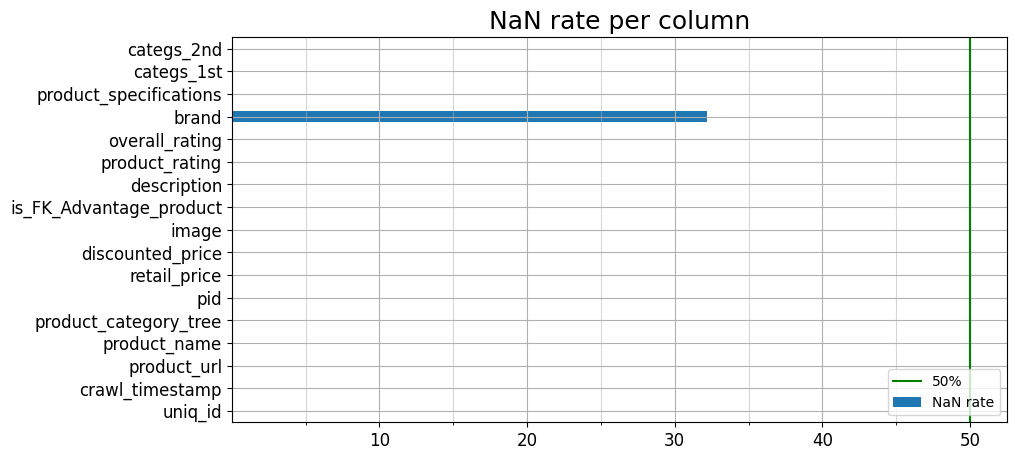

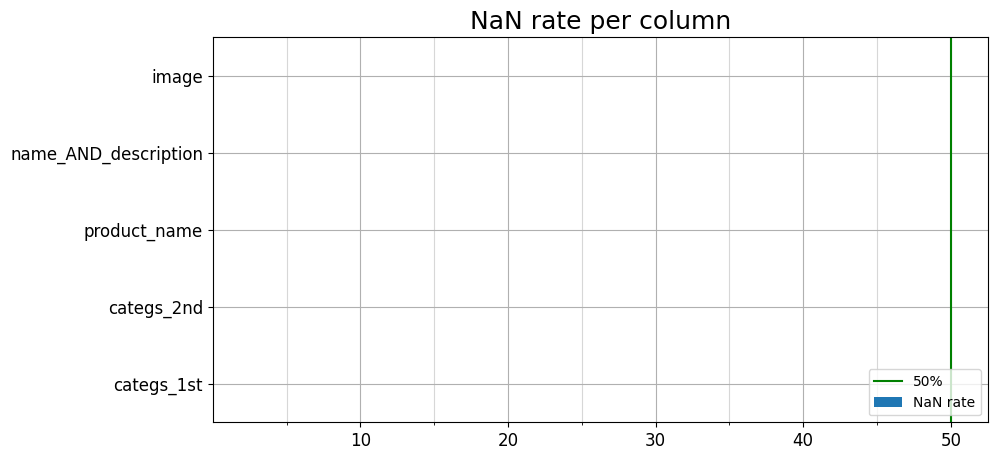

In [62]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
DisplotData.print_nan_rates(nan_rate_00, 50., seuil=None)
DisplotData.print_nan_rates(nan_rate_01, 50., seuil=None)

Très peu de valeurs manquantes, et pour des colonnes qui ne joueront pas de rôle (`brand`, `retail_price`,  `discounted_price`, et `product_specifications` si on l'écarte.

# Exports

In [63]:
with open(data_processed_dir+'data_01.pkl', 'wb') as output:
    pickle.dump(data_01, output, pickle.HIGHEST_PROTOCOL)